### **Perception Algorithm in Python**

#### Introduction
The Perceptron is one of the simplest types of artificial neural networks and was invented by Frank Rosenblatt in 1958. It serves as a linear binary classifier, meaning it attempts to separate data into two parts using a straight line (in 2D), plane (in 3D), or hyperplane (in higher dimensions).

The Perceptron algorithm is inspired by the way neurons work in the human brain. It makes a decision by weighing input features, summing them up, and passing the result through an activation function.

#### How it Works
A perceptron takes several binary inputs, applies individual weights to them, sums the result, and then passes it through a step activation function to determine the output.


**Sumation function:**
$$
z = \sum_{i=1}^{n} w_i x_i + b
$$

**Activation (step) function:**
$$
\text{Output} =
\begin{cases}
1 & \text{if } z \geq 0 \\
0 & \text{if } z < 0
\end{cases}
$$

This function determines whether the neuron “fires” or not.

#### Dataset: General Social Survey 2018

We use the General Social Survey (GSS) 2018 dataset, a sociological survey that captures a wide array of attitudes and demographic details of U.S. residents.

For this example, we will predict subjective happiness (HAPPY) based on selected features such as:
- AGE
- EDUCATION
- INCOME
- MARITAL STATUS

To simplify the task, happiness is binarized:
- `Happy` if response is `Very Happy`
- `Not Happy` if response is anything else


### Import Required Libraries

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Load and Clean Data

In [65]:
df = pd.read_csv("General Social Survey_2018.csv")
df = df[["HAPPY", "HEALTH", "SATFIN"]]
df = df.dropna()
df = df[df['HAPPY'].isin([1, 2])]  # 1 = Very Happy, 2 = Pretty Happy

### Data Preparation and Binary Label Conversion
In this step, we prepare the features and labels for training the Perceptron model. Specifically, we select two features from the GSS dataset:

`HEALTH`: Self-rated health status<br>
`SATFIN`: Satisfaction with financial situation<br>
These features are stored in matrix `X`, while the target variable `HAPPY` serves as the label. Since the Perceptron is a binary classifier, we simplify the multiclass `HAPPY` column into a binary format:

`1` (Very Happy) is treated as the positive class.
All other responses (e.g., Pretty Happy, Not Too Happy) are treated as the negative class (`0`).
We then split the dataset into training and testing sets using an 80/20 ratio. This allows the model to learn from the training data and be evaluated on unseen test data for generalization performance. The `random_state=42` ensures reproducibility.

In [67]:
X = df[["HEALTH", "SATFIN"]]
y = df["HAPPY"]

# Convert labels to binary: 1 = Very Happy, 0 = Pretty Happy
y = (y == 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Building the Perceptron Classifier

In this step, we implement the Perceptron algorithm manually using Python. 

This class includes the following components:

- `__init__`: Initializes key hyperparameters such as the learning rate and number of iterations (epochs), along with placeholders for the weights and bias.
- `fit(X, y)`: Trains the model on input features `X` and binary target `y` by iteratively adjusting weights and bias based on the **Perceptron learning rule**:
  
  $$ \text{update} = \eta \cdot (y_i - \hat{y}_i) $$

  where $\eta$ is the learning rate, $y_i$ is the true label, and $\hat{y}_i$ is the predicted label.

- `predict(X)`: Uses the trained weights and bias to compute predictions for unseen data.
- `_unit_step_func(x)`: The activation function that converts continuous outputs into binary predictions (0 or 1) using a step function:

  $$
  \text{output} = 
  \begin{cases}
  1 & \text{if } x \geq 0 \\
  0 & \text{otherwise}
  \end{cases}
  $$

This structure allows us to train and evaluate a linear binary classifier that makes decisions based on a weighted sum of the inputs.


In [69]:
class Perceptron:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.activation_func = self._unit_step_func
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = self.activation_func(linear_output)
                update = self.lr * (y[idx] - y_predicted)
                self.weights += update * x_i
                self.bias += update

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        y_predicted = self.activation_func(linear_output)
        return y_predicted

    def _unit_step_func(self, x):
        return np.where(x >= 0, 1, 0)

### Initializing and Training the Perceptron Model

With our `Perceptron` class defined, we now initialize an instance of the model with a **learning rate** of `0.01` and train it over `1000` iterations (epochs).

- `learning_rate=0.01` controls how much the weights are adjusted during each step of training. A smaller value ensures more gradual learning, which can improve stability.
- `n_iters=1000` defines how many times the algorithm will pass through the training dataset to update the weights.

The `.fit()` method is then called with the training features and labels to begin the learning process. We use `.values` to ensure that the input to the Perceptron is in NumPy array format, which the class expects.


In [73]:
ppn = Perceptron(learning_rate=0.01, n_iters=1000)
ppn.fit(X_train.values, y_train.values)

### Model Evaluation: Predictions and Performance Metrics

After training the Perceptron model, we evaluate its performance on the unseen **test dataset**:

- `ppn.predict(X_test.values)` generates predicted labels for the test set.
- `classification_report(y_test, y_pred)` provides key evaluation metrics, including:
  - **Precision**: the proportion of positive predictions that were actually correct.
  - **Recall**: the proportion of actual positives that were correctly identified.
  - **F1-score**: the harmonic mean of precision and recall, giving a balanced measure.

To visualize the model's performance, we generate a **confusion matrix**, which shows:
- True Positives (correct positive predictions),
- True Negatives (correct negative predictions),
- False Positives (incorrect positive predictions),
- False Negatives (incorrect negative predictions).

The matrix is displayed using `seaborn`’s `heatmap`, making it easier to interpret prediction accuracy across both classes.



Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.90      0.77       268
           1       0.44      0.16      0.24       134

    accuracy                           0.65       402
   macro avg       0.56      0.53      0.51       402
weighted avg       0.60      0.65      0.60       402



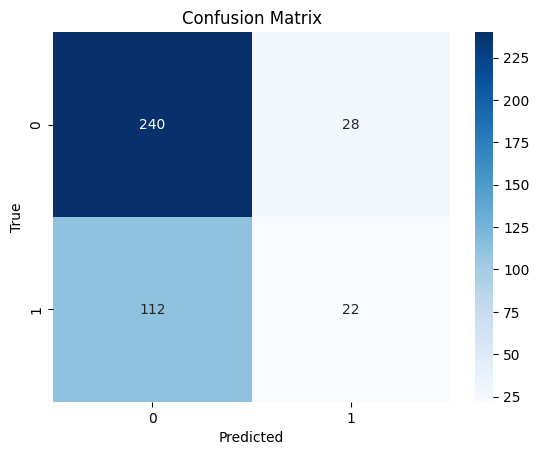

In [75]:
y_pred = ppn.predict(X_test.values)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Conclusion
In this section, we successfully implemented a Perceptron model from scratch to classify happiness based on health and financial satisfaction. While the model showed decent performance, especially for the majority class, it also revealed some of the limitations of linear classifiers on real-world data. This sets the stage for exploring more advanced models in future sections.